# Relative Momentum

Description

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import historic_sp500, STAR_DATE, END_DATE

### Importando os dados

In [2]:
IBOV = yf.Ticker('^BVSP')

ibov_prices = IBOV.history(start=STAR_DATE, end=END_DATE)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

In [3]:
sp500_prices = historic_sp500(start=STAR_DATE, end=END_DATE, brl=True)

In [4]:
relative_prices = pd.merge(ibov_prices, sp500_prices, left_index=True, right_index=True, how='left')
relative_prices = (relative_prices / relative_prices.iloc[0])
relative_prices = relative_prices.set_axis(['IBOV', 'SP500 BRL'], axis=1)

relative_prices['SP500 BRL'] = relative_prices['SP500 BRL'].ffill()

relative_prices

,IBOV,SP500 BRL
2004-01-02,1.000000,1.000000
2004-01-05,1.048429,1.004152
2004-01-06,1.050390,1.001270
2004-01-07,1.038984,1.011210
2004-01-08,1.056672,1.011452
...,...,...
2024-09-03,5.985877,9.716471
2024-09-04,6.064201,9.724193
2024-09-05,6.081622,9.641519
2024-09-06,5.995634,9.416444


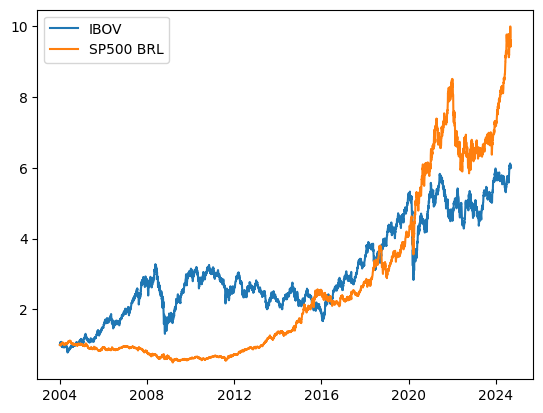

In [5]:

plt.plot(relative_prices)
plt.legend(relative_prices.columns)
plt.show()

In [6]:
ytd_returns = relative_prices.pct_change(periods=252).dropna()

ytd_returns

,IBOV,SP500 BRL
2005-01-06,0.085632,0.010189
2005-01-07,0.051632,-0.001890
2005-01-10,0.030370,0.002217
2005-01-11,0.045026,-0.008823
2005-01-12,0.033436,-0.004859
...,...,...
2024-09-03,0.143089,0.415168
2024-09-04,0.175986,0.402245
2024-09-05,0.157847,0.385041
2024-09-06,0.142600,0.352708


In [7]:
time_series = pd.to_datetime(ytd_returns.index).to_series()
first_trading_day = time_series.groupby(time_series.index.to_period('M')).apply(lambda x: x == x.min())

ytd_returns.loc[first_trading_day.values]

,IBOV,SP500 BRL
2005-01-06,0.085632,0.010189
2005-02-01,-0.003178,-0.049707
2005-03-01,0.299620,-0.078977
2005-04-01,0.274952,-0.043001
2005-05-02,0.158554,-0.115155
...,...,...
2024-05-02,0.235118,0.249861
2024-06-03,0.106034,0.312954
2024-07-01,0.061222,0.459048
2024-08-01,0.059973,0.425815


In [8]:
conditions = [
    first_trading_day.values & (ytd_returns['IBOV'] > ytd_returns['SP500 BRL']),
    first_trading_day.values & (ytd_returns['IBOV'] <= ytd_returns['SP500 BRL']),
]

cases = ['IBOV', 'SP500 BRL']

ytd_returns['Investment'] = np.select(conditions, cases, default=None)
ytd_returns['Investment'] = ytd_returns['Investment'].ffill()

ytd_returns

,IBOV,SP500 BRL,Investment
2005-01-06,0.085632,0.010189,IBOV
2005-01-07,0.051632,-0.001890,IBOV
2005-01-10,0.030370,0.002217,IBOV
2005-01-11,0.045026,-0.008823,IBOV
2005-01-12,0.033436,-0.004859,IBOV
...,...,...,...
2024-09-03,0.143089,0.415168,SP500 BRL
2024-09-04,0.175986,0.402245,SP500 BRL
2024-09-05,0.157847,0.385041,SP500 BRL
2024-09-06,0.142600,0.352708,SP500 BRL


In [9]:
ytd_returns['Investment'].value_counts(normalize=True).round(2)

Investment
SP500 BRL    0.54
IBOV         0.46
Name: proportion, dtype: float64

In [10]:
relative_momentum = relative_prices.pct_change().join(ytd_returns[['Investment']], how='right')

relative_momentum

,IBOV,SP500 BRL,Investment
2005-01-06,-0.013162,0.007617,IBOV
2005-01-07,0.015595,-0.007854,IBOV
2005-01-10,-0.018386,0.001233,IBOV
2005-01-11,0.003211,-0.001199,IBOV
2005-01-12,0.005745,0.004241,IBOV
...,...,...,...
2024-09-03,-0.004653,-0.027000,SP500 BRL
2024-09-04,0.013085,0.000795,SP500 BRL
2024-09-05,0.002873,-0.008502,SP500 BRL
2024-09-06,-0.014139,-0.023344,SP500 BRL


In [11]:
relative_momentum['Relative Momentum'] = relative_momentum.apply(lambda row: row[row['Investment']], axis=1)
relative_momentum = relative_momentum.drop(columns=['Investment'])

relative_momentum

,IBOV,SP500 BRL,Relative Momentum
2005-01-06,-0.013162,0.007617,-0.013162
2005-01-07,0.015595,-0.007854,0.015595
2005-01-10,-0.018386,0.001233,-0.018386
2005-01-11,0.003211,-0.001199,0.003211
2005-01-12,0.005745,0.004241,0.005745
...,...,...,...
2024-09-03,-0.004653,-0.027000,-0.027000
2024-09-04,0.013085,0.000795,0.000795
2024-09-05,0.002873,-0.008502,-0.008502
2024-09-06,-0.014139,-0.023344,-0.023344


In [12]:
relative_momentum_eval = (1 + relative_momentum).cumprod()
relative_momentum_eval = (relative_momentum_eval / relative_momentum_eval.iloc[0]) - 1

relative_momentum_eval

,IBOV,SP500 BRL,Relative Momentum
2005-01-06,0.000000,0.000000,0.000000
2005-01-07,0.015595,-0.007854,0.015595
2005-01-10,-0.003078,-0.006631,-0.003078
2005-01-11,0.000123,-0.007822,0.000123
2005-01-12,0.005869,-0.003614,0.005869
...,...,...,...
2024-09-03,4.513728,8.618469,15.431781
2024-09-04,4.585874,8.626113,15.444839
2024-09-05,4.601921,8.544273,15.305028
2024-09-06,4.522715,8.321468,14.924396


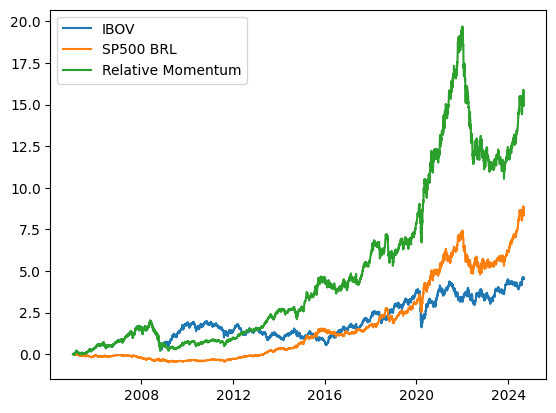

In [13]:
plt.plot(relative_momentum_eval)
plt.legend(relative_momentum_eval.columns)
plt.show()

In [14]:
relative_momentum_eval = relative_momentum_eval + 1
relative_momentum_eval.index = pd.to_datetime(relative_momentum_eval.index).date

series_start = relative_momentum_eval.index.min()
series_end = relative_momentum_eval.index.max()

years = (series_end - series_start).days / 365.25

avg_return = (relative_momentum_eval.iloc[-1] / (relative_momentum_eval.iloc[0])) ** (1 / years) - 1
avg_vol = relative_momentum.std() * (252 ** 0.5)

In [15]:
total_results = pd.concat([avg_return, avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

total_results


,Avg Return,Avg Vol
IBOV,0.090810,0.266251
SP500 BRL,0.121210,0.209242
Relative Momentum,0.152149,0.241274


In [16]:
total_results['Sharpe Ratio'] = (total_results['Avg Return'] - 0.1050) / total_results['Avg Vol']

total_results

,Avg Return,Avg Vol,Sharpe Ratio
IBOV,0.090810,0.266251,-0.053295
SP500 BRL,0.121210,0.209242,0.077471
Relative Momentum,0.152149,0.241274,0.195416


In [17]:
export_relative_model = pd.DataFrame({'Daily Var': relative_momentum['Relative Momentum'], 'Return': relative_momentum_eval['Relative Momentum']})

export_relative_model.to_csv('data/export_relative_model.csv')